# **Time Series Forecasting**

Case : BBCA Prices Prediction

Data Scientist:

1. **Nabila Avicenna**
2. **Iwana Amalia**
3. **Kerin Aurelia**
4. **Nabila Lailinajma**

### **Business Problem Understanding**

**Context**

PT Bank Central Asia Tbk (BBCA) adalah bank swasta terbesar di Indonesia dengan kapitalisasi pasar tertinggi di Bursa Efek Indonesia. Dengan kepemilikan mayoritas oleh Djarum Group (54.94%) dan sisanya oleh publik (45.06%), BBCA dikenal sebagai saham blue-chip yang stabil dan memiliki tren pertumbuhan jangka panjang yang positif. Keputusan investasi pada saham BBCA memerlukan analisis prediktif yang akurat untuk membantu investor mengoptimalkan keuntungan dan meminimalkan risiko.

**Problem Statement**

1. Bagaimana memprediksi pergerakan harga saham BBCA secara akurat untuk periode Januari-Juni 2025?
2. Model time series apa yang paling optimal untuk memprediksi harga saham BBCA berdasarkan data historis 2021-2025?

**Goals**

1. Mengembangkan model forecasting yang dapat memprediksi harga saham BBCA dengan akurat
2. Memberikan insight tentang tren dan pola pergerakan harga saham BBCA
3. Membantu investor dalam pengambilan keputusan investasi berdasarkan prediksi harga yang reliable

**Analytic Approach**
1. Data Understanding & Preparation:
   - Analisis data historis harga saham BBCA 2021-2025
   - Preprocessing data dan pemeriksaan missing values
   - Analisis pola seasonality dan trend
       


2. Modeling:
   - Implementasi model Prophet
   - Parameter tuning untuk optimasi model
   - Validasi model menggunakan data testing

3. Evaluation & Forecasting:

   - Evaluasi performa model
   - Forecasting harga untuk periode target
   - Analisis hasil prediksi

**Metric Evaluation**
- Mean Absolute Error (MAE): Mengukur rata-rata absolut dari error prediksi
- Mean Absolute Percentage Error (MAPE): Mengukur akurasi dalam bentuk persentase untuk perbandingan performa model pada skala yang berbeda

### **Data Understanding and Preparation**

In [742]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#forecasting
import prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import plotly.graph_objects as go

In [743]:
df=pd.read_csv("bbca.csv")

# Menghapus kolom 'Unnamed: 0'
df = df.drop(columns=['Unnamed: 0'])

# Mengubah kolom 'Date' menjadi tipe datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Mengubah nama kolom
df = df.rename(columns={'Date': 'ds', 'Close': 'y'})
df

,ds,y
0,2021-02-05,6328.151367
1,2021-02-08,6332.727051
2,2021-02-09,6387.634277
3,2021-02-10,6332.727051
4,2021-02-11,6296.121094
...,...,...
961,2025-01-24,9350.000000
962,2025-01-30,9150.000000
963,2025-01-31,9450.000000
964,2025-02-03,9350.000000


### **Exploratory Data Analysis**

In [745]:
display(df['ds'].min(), df['ds'].max())
display(df['y'].describe())

Timestamp('2021-02-05 00:00:00')

Timestamp('2025-02-04 00:00:00')

count      966.000000
mean      8114.101610
std       1411.124018
min       5530.654297
25%       6971.922363
50%       8256.613281
75%       9253.845703
max      10895.657227
Name: y, dtype: float64

In [746]:
import plotly.express as px

fig = px.line(df, x='ds', y='y', 
              title='Tren Harga Saham BBCA dari 2021 hingga 2025',
              labels={'ds': 'Tanggal', 'y': 'Harga (IDR)'},
              template='plotly_white')
fig.update_layout(title_x=0.5)  

fig.show()

#### **Ringkasan Data Harga Saham BBCA (2021 - 2025)**

**Periode Waktu**
Dataset berisi harga saham BBCA dari **Februari 2021 hingga Februari 2025** dengan entri harian.

**Fitur Utama**
- **Date**: Tanggal pengamatan.  
- **Close**: Harga penutupan saham BBCA, digunakan untuk analisis tren dan peramalan.  

**Ringkasan Statistik**
- **Rata-rata harga saham**: Rp8.114,10  
- **Nilai minimum**: Rp5.530,65  
- **Nilai maksimum**: Rp10.895,66  
- **Median harga saham**: Rp8.256,61  
- **Kuartil 1 (25%)**: Rp6.971,92  
- **Kuartil 3 (75%)**: Rp9.253,85  

**Standar Deviasi**
Harga saham BBCA cukup **fluktuatif**, dengan **standar deviasi sebesar Rp1.411,12**, menunjukkan adanya variasi harga yang cukup besar dari waktu ke waktu.

**Insight dari Visualisasi Tren Harga Saham BBCA**
- Grafik menunjukkan **tren kenaikan harga saham BBCA dalam jangka panjang**, terutama sejak pertengahan 2021.   
- Sejak **pertengahan 2023 hingga awal 2025**, harga saham cenderung berada di atas Rp8.000, dengan beberapa lonjakan yang mencapai **Rp10.000**.  
- Investor dapat mempertimbangkan **strategi entry saat harga mengalami koreksi sebelum tren naik berikutnya dimulai**.  

**Kesimpulan**
- Data menunjukkan bahwa harga saham BBCA mengalami **tren kenaikan jangka panjang**, tetapi juga memiliki periode volatilitas tinggi.  
- Rentang harga yang cukup luas (**Rp5.530 - Rp10.895**) menunjukkan adanya **peluang investasi**, namun perlu strategi yang tepat untuk mengurangi risiko.

### **Modeling and Evaluation**

**Split Data**

In [750]:
df_train=df[(df['ds']>'2021-02') & (df['ds']<='2023-08')]
df_test=df[df['ds']>'2023-08']

print("Training data length:", len(df_train))
print("Testing data length:", len(df_test))

Training data length: 604
Testing data length: 362


**Insight:**

Dataset dibagi menjadi set pelatihan dan set pengujian untuk menghindari kebocoran data.
- Training Data: Menggunakan data 2 tahun 6 bulan karena perbedaan tren harga saham BBCA (kami ingin tren terbaru dan relevan untuk memperkirakan tren masa depan).
- Test Data: Data 1 tahun 6 bulan terakhir digunakan untuk evaluasi dan peramalan.

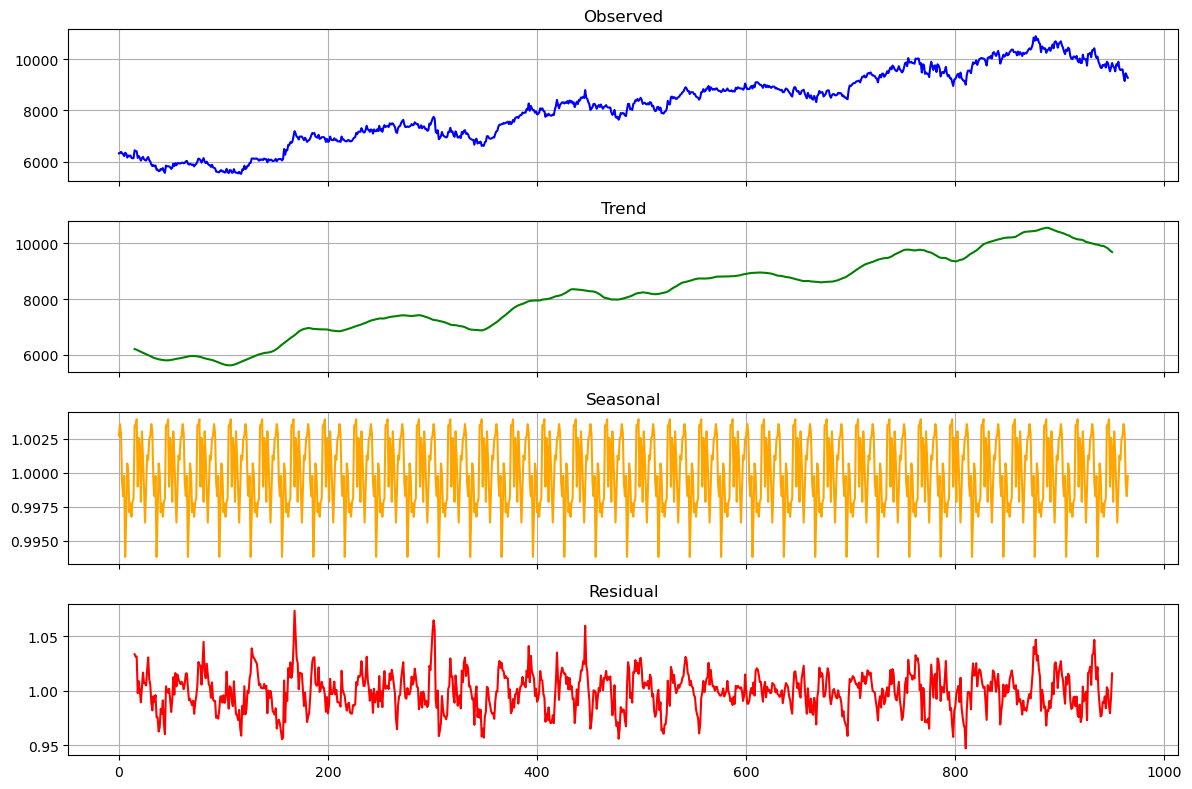

In [752]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['y'], model='multiplicative', period=30)

fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

result.observed.plot(ax=axes[0], title='Observed', color='blue')
result.trend.plot(ax=axes[1], title='Trend', color='green')
result.seasonal.plot(ax=axes[2], title='Seasonal', color='orange')
result.resid.plot(ax=axes[3], title='Residual', color='red')

for ax in axes:
    ax.grid(True)
    
plt.tight_layout()
plt.show()

## **Prophet Tanpa Tuning**

In [754]:
model=prophet.Prophet(yearly_seasonality=True)
model.fit(df_train)

21:55:18 - cmdstanpy - INFO - Chain [1] start processing
21:55:18 - cmdstanpy - INFO - Chain [1] done processing


In [755]:
forecast = model.predict(df_test[['ds']])
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-08-02,9411.721556,8902.389116,9278.605483,9411.721556,9411.721556,-340.235899,-340.235899,-340.235899,-8.143070,-8.143070,-8.143070,-332.092829,-332.092829,-332.092829,0.0,0.0,0.0,9071.485656
1,2023-08-03,9418.717107,8922.662058,9283.367613,9418.717107,9418.717107,-313.999593,-313.999593,-313.999593,-3.789234,-3.789234,-3.789234,-310.210359,-310.210359,-310.210359,0.0,0.0,0.0,9104.717514
2,2023-08-04,9425.712658,8934.634600,9318.857649,9425.712658,9425.712658,-289.863994,-289.863994,-289.863994,-2.250667,-2.250667,-2.250667,-287.613327,-287.613327,-287.613327,0.0,0.0,0.0,9135.848664
3,2023-08-07,9446.699311,9039.579928,9398.844225,9446.699311,9446.699311,-227.214018,-227.214018,-227.214018,-10.059424,-10.059424,-10.059424,-217.154594,-217.154594,-217.154594,0.0,0.0,0.0,9219.485294
4,2023-08-08,9453.694863,9046.212109,9428.629397,9453.694863,9453.694863,-205.729627,-205.729627,-205.729627,-12.380183,-12.380183,-12.380183,-193.349445,-193.349445,-193.349445,0.0,0.0,0.0,9247.965235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,2025-01-24,13196.314733,10160.826593,16128.625610,10165.840548,16088.852846,-31.692985,-31.692985,-31.692985,-2.250667,-2.250667,-2.250667,-29.442318,-29.442318,-29.442318,0.0,0.0,0.0,13164.621748
358,2025-01-30,13238.288040,10236.446035,16218.040279,10192.683065,16155.917262,15.996343,15.996343,15.996343,-3.789234,-3.789234,-3.789234,19.785576,19.785576,19.785576,0.0,0.0,0.0,13254.284383
359,2025-01-31,13245.283591,10207.931121,16167.892898,10184.547827,16181.383465,27.924436,27.924436,27.924436,-2.250667,-2.250667,-2.250667,30.175103,30.175103,30.175103,0.0,0.0,0.0,13273.208027
360,2025-02-03,13266.270245,10206.102973,16358.159932,10191.238255,16220.173047,51.283983,51.283983,51.283983,-10.059424,-10.059424,-10.059424,61.343407,61.343407,61.343407,0.0,0.0,0.0,13317.554228


In [756]:
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"
fig = go.Figure()

# Plot training data
fig.add_trace(go.Scatter(
    x=df_train['ds'], 
    y=df_train['y'], 
    mode='lines', 
    name='Train',
    line=dict(color='blue')
))

# Plot actual test data
fig.add_trace(go.Scatter(
    x=df_test['ds'], 
    y=df_test['y'], 
    mode='lines', 
    name='Test Actual',
    line=dict(color='green')
))

# Plot predictions
fig.add_trace(go.Scatter(
    x=forecast['ds'], 
    y=forecast['yhat'], 
    mode='lines', 
    name='Prediction',
    line=dict(color='red', dash='dash')
))

# Update layout
fig.update_layout(
    title='Prophet Model Without Tuning: Predictions vs Actual Data',
    xaxis_title='Date',
    yaxis_title='Close Price',
    xaxis=dict(tickangle=45),
    legend=dict(x=0, y=1),
    template="plotly_white"
)

# Show figure
fig.show()
y_actual = df_test['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_actual, y_pred)
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")

MAE: 1842.4997677178842
MAPE: 19.22%


Berdasarkan grafik Prophet Model tanpa Hyperparameter Tuning, berikut beberapa insight utama:

**Performa Model:**
- MAE (Mean Absolute Error): 1842.50
- MAPE (Mean Absolute Percentage Error): 19.22%

**Artinya, Model memiliki error yang cukup signifikan, menandakan ada ruang untuk perbaikan. Dan Perlu dilakukan hyperparameter tuning.**

## **Prophet dengan Tuning**

In [759]:
from prophet import Prophet
import itertools

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1], 
    'seasonality_prior_scale': [0.01, 0.1, 1, 5, 10],
    'holidays_prior_scale': [0.01, 0.1, 1],
    'seasonality_mode': ['additive', 'multiplicative']
}

# iterasi kombinasi parameter
param_combinations = list(itertools.product(
    param_grid['changepoint_prior_scale'],
    param_grid['seasonality_prior_scale'],
    param_grid['holidays_prior_scale'],
    param_grid['seasonality_mode']
))

results = []
for (changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale, seasonality_mode) in param_combinations:

    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_mode=seasonality_mode,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        holidays=holidays
    )
    
    
    model.fit(df_train)
    forecast = model.predict(df_test[['ds']])
    
    # evaluasi metrics
    forecast_test = forecast[-len(df_test):]
    mae = mean_absolute_error(df_test['y'].values, forecast_test['yhat'].values)
    mape = mean_absolute_percentage_error(df_test['y'].values, forecast_test['yhat'].values)
    results.append((changepoint_prior_scale, seasonality_prior_scale, 
                    holidays_prior_scale, seasonality_mode, mae, mape))

21:55:19 - cmdstanpy - INFO - Chain [1] start processing
21:55:19 - cmdstanpy - INFO - Chain [1] done processing
21:55:19 - cmdstanpy - INFO - Chain [1] start processing
21:55:19 - cmdstanpy - INFO - Chain [1] done processing
21:55:19 - cmdstanpy - INFO - Chain [1] start processing
21:55:19 - cmdstanpy - INFO - Chain [1] done processing
21:55:19 - cmdstanpy - INFO - Chain [1] start processing
21:55:19 - cmdstanpy - INFO - Chain [1] done processing
21:55:19 - cmdstanpy - INFO - Chain [1] start processing
21:55:19 - cmdstanpy - INFO - Chain [1] done processing
21:55:20 - cmdstanpy - INFO - Chain [1] start processing
21:55:20 - cmdstanpy - INFO - Chain [1] done processing
21:55:20 - cmdstanpy - INFO - Chain [1] start processing
21:55:20 - cmdstanpy - INFO - Chain [1] done processing
21:55:20 - cmdstanpy - INFO - Chain [1] start processing
21:55:20 - cmdstanpy - INFO - Chain [1] done processing
21:55:20 - cmdstanpy - INFO - Chain [1] start processing
21:55:20 - cmdstanpy - INFO - Chain [1]

In [760]:
results_df = pd.DataFrame(results, columns=['Changepoint Prior Scale', 'Seasonality Prior Scale', 'Holidays Prior Scale',
                                            'Seasonality Mode', 'MAE', 'MAPE'])
results_df

,Changepoint Prior Scale,Seasonality Prior Scale,Holidays Prior Scale,Seasonality Mode,MAE,MAPE
0,0.001,0.01,0.01,additive,475.627153,0.050892
1,0.001,0.01,0.01,multiplicative,522.797003,0.055825
2,0.001,0.01,0.10,additive,475.627153,0.050892
3,0.001,0.01,0.10,multiplicative,522.797003,0.055825
4,0.001,0.01,1.00,additive,475.627153,0.050892
...,...,...,...,...,...,...
145,1.000,10.00,0.01,multiplicative,3555.168646,0.363895
146,1.000,10.00,0.10,additive,682.963215,0.070372
147,1.000,10.00,0.10,multiplicative,3555.168646,0.363895
148,1.000,10.00,1.00,additive,682.963215,0.070372


In [761]:
# Define best parameter
best_params = results_df.sort_values(by=['MAE', 'MAPE']).iloc[0]

# Define best model
best_model = Prophet(
    changepoint_prior_scale=best_params['Changepoint Prior Scale'],
    seasonality_mode=best_params['Seasonality Mode'],
    seasonality_prior_scale=best_params['Seasonality Prior Scale'],
    holidays_prior_scale=best_params['Holidays Prior Scale'],
)

# Fit to all data
best_model.fit(df)

21:56:10 - cmdstanpy - INFO - Chain [1] start processing
21:56:10 - cmdstanpy - INFO - Chain [1] done processing


In [762]:
# Predict only on test dataset dates
best_forecast = best_model.predict(df_test[['ds']])
best_forecast[['ds', 'yhat']].tail()

,ds,yhat
357,2025-01-24,9558.085557
358,2025-01-30,9547.640204
359,2025-01-31,9548.952762
360,2025-02-03,9553.309462
361,2025-02-04,9556.124982


In [763]:
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"
fig = go.Figure()

# Plot training data
fig.add_trace(go.Scatter(
    x=df_train['ds'], 
    y=df_train['y'], 
    mode='lines', 
    name='Train',
    line=dict(color='blue')
))

# Plot actual test data
fig.add_trace(go.Scatter(
    x=df_test['ds'], 
    y=df_test['y'], 
    mode='lines', 
    name='Test Actual',
    line=dict(color='green')
))

# Plot predictions
fig.add_trace(go.Scatter(
    x=best_forecast['ds'], 
    y=best_forecast['yhat'], 
    mode='lines', 
    name='Prediction',
    line=dict(color='red', dash='dash')
))

# Update layout
fig.update_layout(
    title='Prophet Model with Tuning Parameter: Predictions vs Actual Data',
    xaxis_title='Date',
    yaxis_title='Close Price',
    xaxis=dict(tickangle=45),
    legend=dict(x=0, y=1),
    template="plotly_white"
)

# Show figure
fig.show()
print(best_params)

Changepoint Prior Scale           0.5
Seasonality Prior Scale           0.1
Holidays Prior Scale             0.01
Seasonality Mode             additive
MAE                        373.383697
MAPE                         0.040394
Name: 96, dtype: object


Berdasarkan grafik Prophet Model dengan Hyperparameter Tuning, berikut beberapa insight utama:

**Performa Model:**
- MAE turun dari 1842.50 menjadi 373.38
- MAPE menurun dari 19.22% menjadi 4.04%

**Artinya, Model prediksi sudah sangat membaik setelah penyetelan parameter dan kesalahan prediksi berkurang.**

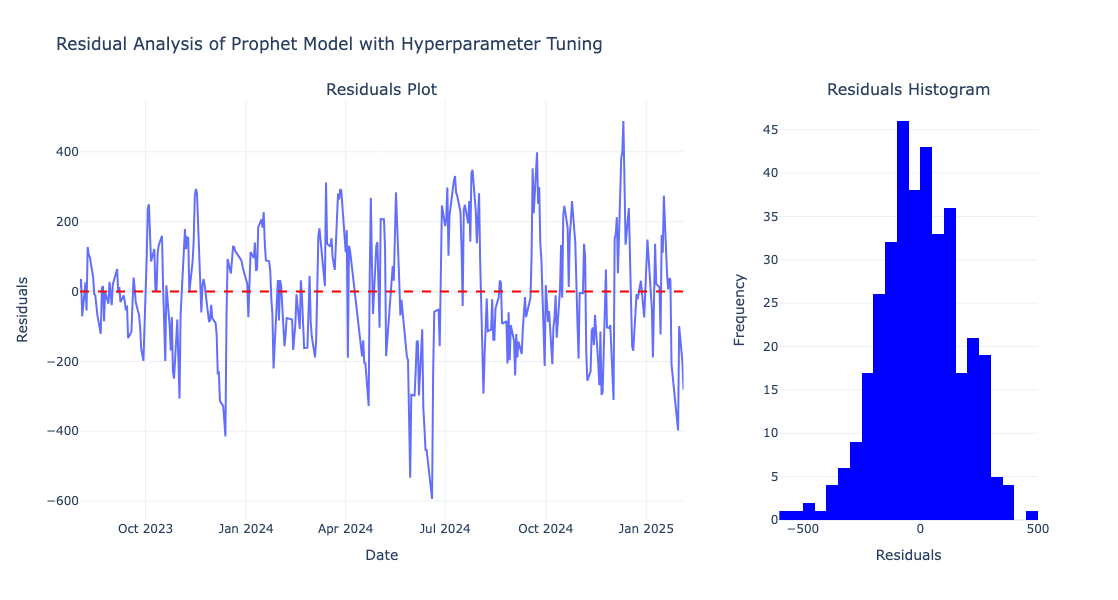

In [802]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, 
                    subplot_titles=('Residuals Plot', 'Residuals Histogram'), 
                    column_widths=[0.7, 0.3])

fig.add_trace(go.Scatter(x=best_forecast['ds'], y=residuals, mode='lines', name='Residuals'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=best_forecast['ds'], y=[0]*len(best_forecast), mode='lines', 
                         line=dict(color='red', dash='dash'), name='Zero Residual'),
              row=1, col=1)

fig.add_trace(go.Histogram(x=residuals, nbinsx=30, name='Residuals', marker=dict(color='blue')),
              row=1, col=2)

# Update layout
fig.update_layout(title_text='Residual Analysis of Prophet Model with Hyperparameter Tuning', 
                  height=600, 
                  showlegend=False,
                  xaxis_title='Date', 
                  yaxis_title='Residuals', 
                  xaxis2_title='Residuals', 
                  yaxis2_title='Frequency')

fig.show()

## **Interpretasi Model dan Parameter**

Berdasarkan informasi yang diberikan, berikut adalah interpretasi model Prophet dengan hyperparameter tuning yang telah dilakukan:

**Parameter Model:**
- **Changepoint Prior Scale (0.5):**
  Nilai ini mengontrol fleksibilitas model dalam mendeteksi perubahan tren. Nilai 0.5 menunjukkan bahwa model cukup fleksibel dalam menangkap perubahan tren, tetapi tidak terlalu sensitif terhadap fluktuasi kecil. Ini adalah nilai yang seimbang antara underfitting dan overfitting.

- **Seasonality Prior Scale (0.1):**
  Parameter ini mengontrol kekuatan komponen musiman. Nilai 0.1 menunjukkan bahwa model memberikan bobot yang relatif kecil pada komponen musiman, yang mungkin cocok untuk data yang tidak memiliki musiman yang sangat kuat.

- **Holidays Prior Scale (0.01):**
  Parameter ini mengontrol pengaruh hari libur pada prediksi. Nilai 0.01 menunjukkan bahwa model memberikan bobot yang sangat kecil pada efek hari libur, yang mungkin berarti bahwa hari libur tidak memiliki dampak yang signifikan pada data Anda.

- **Seasonality Mode (additive):**
  Mode additive menunjukkan bahwa efek musiman ditambahkan ke tren. Ini cocok untuk data di mana fluktuasi musiman relatif konstan sepanjang waktu.

**Performa Model:**
- **MAE (Mean Absolute Error): 373.38**
  MAE yang lebih rendah (dari 1842.50 menjadi 373.38) menunjukkan bahwa model telah mengalami peningkatan yang signifikan dalam akurasi prediksi setelah tuning parameter.

**MAPE (Mean Absolute Percentage Error): 4.04%**

MAPE yang rendah (dari 19.22% menjadi 4.04%) menunjukkan bahwa kesalahan prediksi relatif terhadap nilai aktual telah berkurang secara signifikan. Ini menunjukkan bahwa model sekarang lebih akurat dalam memprediksi nilai aktual.

Interpretasi Residual
Residuals Plot:

Plot residual menunjukkan seberapa baik model cocok dengan data. Jika residual terdistribusi secara acak di sekitar nol, itu menunjukkan bahwa model menangkap pola data dengan baik. Jika ada pola atau tren dalam residual, itu mungkin menunjukkan bahwa model tidak menangkap beberapa aspek dari data.

Residuals Histogram:

Histogram residual memberikan gambaran tentang distribusi kesalahan prediksi. Distribusi yang simetris dan berpusat di sekitar nol adalah indikator yang baik. Jika distribusi miring atau memiliki ekor yang panjang, itu mungkin menunjukkan bahwa model memiliki bias atau varians yang tinggi.